In [34]:
# Important necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from matplotlib.lines import Line2D
from tqdm import *
from itertools import compress
from scipy.optimize import bisect
from matplotlib.ticker import FuncFormatter


%matplotlib inline  

In [35]:
def combine_background_files(folder='../data/bkg_Zj/', lumi=37*1000, nfiles=200, cut=None, kf=1.0):
    """ Read .evt and .meta files as output by monojet.C and 
        properly weigh events
    """
    
    evt_frames = [pd.read_csv(folder+'events_'+str(i)+'.evt', header=0, delimiter=',', skipinitialspace=True) for i in range(nfiles)]
    good_frames = np.array([len(evt_frame) for evt_frame in evt_frames]) > 0
    
    evt_frames = list(compress(evt_frames, good_frames))
    meta_frames = [pd.read_csv(folder+'events_'+str(i)+'.meta', header=0, delimiter=',', skipinitialspace=True) for i in compress(range(nfiles),good_frames)]
    sum_weights = np.sum([meta_frame['sum_weight'] for meta_frame in meta_frames])
    for evt_frame, meta_frame in zip(evt_frames, meta_frames):
        evt_frame['weight'] *= (meta_frame['cxn']*lumi/sum_weights)[0]*5000*kf

    data = pd.concat(evt_frames)
    
    if cut is not None:
        data = data.query(cut)
    return data

In [36]:
def to_str(num):
    if .2 <= num <= .9:
        return '{:.1g}'.format(num)[-2:]
    elif num == 0:
        return '0.0'
    elif num == 0.99:
        return '0.99'
    elif num == 1:
        return '1.0'
    else:
        return str(num)

def combine_signal_files(folder='../data/bkg_Zj/', mphi = 1700, rinv = 1, lumi=37*1000, nfiles=4, cut = None,extra='', return_cxn = False):
    """ Read .evt and .meta files as output by monojet.C and 
        properly weigh events
    """
    
    evt_frames = [pd.read_csv(folder+'events_reclustered_'+str(extra)+str(mphi)+"_"+to_str(rinv)+"_"+str(i)+'.evt', header=0, delimiter=',', skipinitialspace=True) for i in range(nfiles)]
    good_frames = np.array([len(evt_frame) for evt_frame in evt_frames]) > 0
    
    evt_frames = list(compress(evt_frames, good_frames))
    meta_frames = [pd.read_csv(folder+'events_reclustered_'+str(mphi)+"_"+to_str(rinv)+"_"+str(i)+'.meta', header=0, delimiter=',', skipinitialspace=True) for i in compress(range(nfiles),good_frames)]
    sum_weights = np.sum([meta_frame['sum_weight'] for meta_frame in meta_frames])
    mean_cxn  = np.mean([meta_frame['cxn'] for meta_frame in meta_frames])
    for evt_frame, meta_frame in zip(evt_frames, meta_frames):
        evt_frame['weight'] *= (meta_frame['cxn']*lumi/sum_weights)[0]
    data = pd.concat(evt_frames)
    data['cxn'] = mean_cxn
    
    if cut is not None:
        data = data.query(cut)
    if return_cxn:
        return data, mean_cxn
    else:
        return data

# Backgrounds

In [37]:
Zj_df = combine_background_files('../data/bkg_Zj/', nfiles=1000,kf=1.1)
Wj_df = combine_background_files('../data/bkg_Wj/', nfiles=1000,kf=1.0)
tt_d_df = combine_background_files('../data/bkg_ttbar_dilep//', nfiles=1000,kf=1.7)
tt_s_df = combine_background_files('../data/bkg_ttbar_semilep//', nfiles=1000,kf=1.7)
QCD_df = combine_background_files('../data/bkg_qcd////', nfiles=2000,kf=1.0)

tt_df = pd.concat([tt_d_df, tt_s_df])

bkg_all = pd.concat([Zj_df, Wj_df, tt_s_df, QCD_df])

bkg_total = bkg_all.query('pt2> 100 & MEt > .15*Mt & dphi < 0.4  & 1.1 > eta1-eta2 > -1.1')

## show background distributions vs fit

[  515.43647946   547.26257798   581.05380817   616.93150888   655.02451115
   695.46960081   738.41200965   784.00593694   832.41510312   883.8133377
   938.38520345   996.32665913  1057.84576319  1123.16342078  1192.5141771
  1266.14705952  1344.32647185  1427.33314375  1515.4651388   1609.03892477
  1708.39051004  1813.87665014  1925.87612878  2044.79111802  2171.04862243
  2305.10201233  2447.43265183  2598.5516273   2759.00158263  2929.35866771
  3110.23460737  3302.27889795  3506.18113952  3722.67351214  3952.53340502
  4196.58620797  4455.70827524  4730.83007239  5022.93951742  5333.08552825
  5662.38178919  6012.01075001  6383.22787193  6777.36613576  7195.84082845
  7640.15462514  8111.90298502  8612.77988038  9144.58387938  9709.22460442]
[  7.01797469e+03   7.87064240e+03   4.86584885e+03   3.09412355e+03
   2.71647772e+03   1.70763635e+03   1.61315992e+03   1.06866748e+03
   6.79173768e+02   7.63306482e+02   3.41101320e+02   2.76673362e+02
   1.92386871e+02   1.56488257e+02

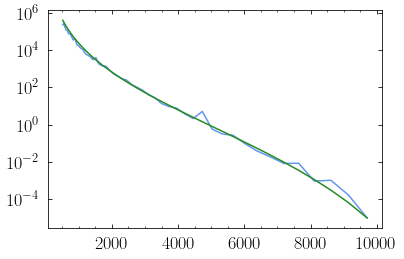

In [38]:
def qcd(x_):
    x=(x_[:-1]+x_[1:])/2.
    bw=(x_[1:]-x_[:-1])
    z=x/13000.
    return 1.1*bw*np.exp( -8.52204 -6.50915*np.log(z) -0.278056*(np.log(z))**2 + 
                   6.39077*np.log(1 - z) - 1.35113*(np.log(1 - z))**2 )


from math import *
bins=10**np.linspace(log10(500),log10(10000),51)
bw=(bins[1:]-bins[:-1])
bc=(bins[1:]+bins[:-1])/2.
res,_=np.histogram(bkg_total['Mt'],weights=bkg_total['weight'],bins=bins)
plt.plot(bc,res)
plt.plot(bc,qcd(bins))
plt.yscale('log')


print(bc)
print(res/bw)

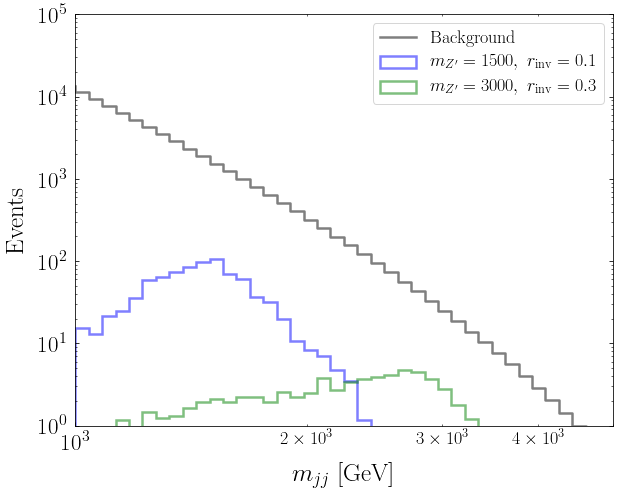

In [39]:
from math import *
bins=10**np.linspace(log10(100),log10(8000),91)

def get_sig(mass, rinv, cut='1.2 > y1-y2 > -1.2 & pt1 > 440 & pt2 > 60'):
    d = combine_signal_files('../data/sig_zprime/', mass, rinv)
    d = d.query(cut)
    sig, _ = np.histogram(d['mjj'],weights=d['weight'],bins=bins)
    return sig

def get_data(mass, rinv, cut='pt2> 80 & MEt > .15*Mt & dphi < 0.4  & 1.1 > eta1-eta2 > -1.1'):
    d = combine_signal_files('../data/sig_zprime/', mass, rinv)
    d = d.query(cut)
    return d

cut='pt2> 80 & MEt > 200 & MEt > .15*Mt & dphi < 1  & 1.1 > eta1-eta2 > -1.1'

mZ_1500 = get_data(1500,0.1).query(cut)
mZ_2000 = get_data(3000,0.3).query(cut)

bkg_cut = bkg_all.query(cut)


bins = bins=10**np.linspace(log10(1000),log10(5000),40+1)
fig=plt.figure(figsize=(9,7))


# if desired, use the smoothed background
qcdx=bins[:-1]
qcdy=qcd(bins)

plt.step(qcdx, qcdy,
         lw=2.5, ls = 'solid', label=r"${\rm Background}$",
         color='black',alpha=.5)

# plt.hist(bkg_cut['Mt'], weights=bkg_cut['weight'],
#          lw=2.5, ls = 'solid', label=r"${\rm Background}$", histtype='step',
#          color='black',alpha=.5, bins=bins)


plt.hist(mZ_1500['Mt'], weights=mZ_1500['weight'],
         lw=2.5, ls = 'solid', label="$m_{Z^\prime}=1500,\; r_{\\rm inv}=0.1$", histtype='step',
         color='blue',alpha=.5, bins=bins)

plt.hist(mZ_2000['Mt'], weights=mZ_2000['weight'],
         lw=2.5, ls = 'solid', label="$m_{Z^\prime}=3000,\; r_{\\rm inv}=0.3$", histtype='step',
         color='green',alpha=.5, bins=bins)


plt.yscale('log', nonposy='clip')
plt.xlabel(r'$m_{jj}$ [GeV]',fontsize=25)
plt.ylabel(r'${\rm Events}$',fontsize=25)  

plt.xlim([1000,5000])
plt.ylim([1,1e5])
plt.yscale('log')

plt.legend()
plt.tick_params(axis='both', which='major', labelsize=23)
plt.tight_layout()
plt.xscale('log')


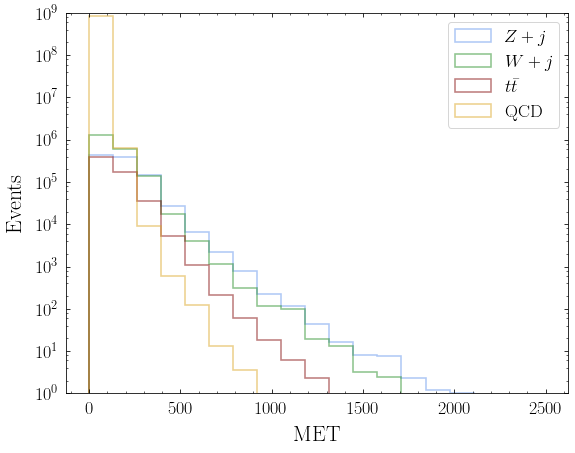

In [40]:
bins = np.linspace(0,2500,20)
normed = False

fig=plt.figure(figsize=(9,7))

plt.hist(Zj_df['MEt'], weights=Zj_df['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=1.6, label="$Z+j$", normed=normed)

plt.hist(Wj_df['MEt'], weights=Wj_df['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=1.6, label="$W+j$", normed=normed)

plt.hist(tt_df['MEt'], weights=tt_df['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=1.6, label="$t\\bar t$", normed=normed)

plt.hist(QCD_df['MEt'], weights=QCD_df['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=1.6, label="QCD", normed=normed)

plt.xlabel("MET")

plt.ylim(1e0,1e9)
plt.legend()
plt.ylabel("Events")
plt.yscale("log")

# Signal

In [41]:
rinvs = [.01, .3, .6, 1.0 ]
sig10 = [ combine_signal_files('../data/sig_zprime/', 1000, rinv) for rinv in rinvs  ]
cxn10 = [ combine_signal_files('../data/sig_zprime/', 1000, rinv ,return_cxn=True)[1] for rinv in rinvs ]

title = "$(\\bar q \gamma^\mu q)(\\bar \chi \gamma_\mu \chi)$"
plot_color=['forestgreen','cornflowerblue', 'maroon','goldenrod','violet','maroon','darkgrey','lightpink','black','forestgreen','cornflowerblue', 'salmon','violet','goldenrod','maroon','darkgrey','lightpink']

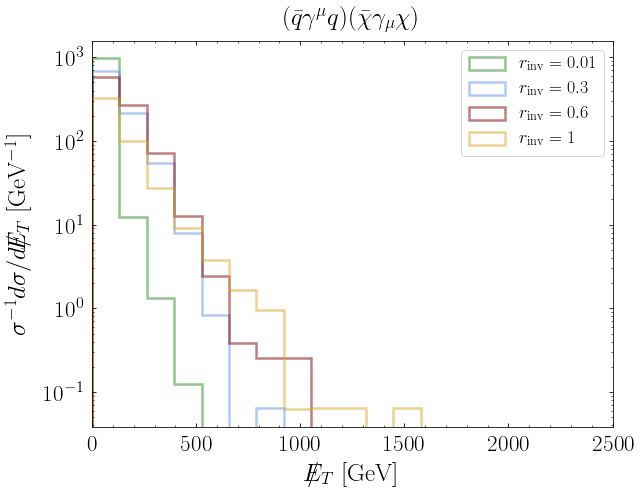

In [42]:
lumi = 37
bins = np.linspace(0,2500,20)
fig=plt.figure(figsize=(9,7))

for irinv, rinv in enumerate(rinvs):
    plt.hist(sig10[irinv]['MEt'], weights=sig10[irinv]['weight'].values/cxn10[irinv]/lumi, lw=2.5, ls = 'solid', label="$r_{\\rm inv}=%0.2g$" % rinv, histtype='step', color=plot_color[irinv],alpha=.5, bins=bins)


    
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\slash \!\!\!\! E_{T}$ [GeV]',fontsize=25)
plt.ylabel(r'${\sigma^{-1}d\sigma/d\slash \!\!\!\! E_{T}}$ [GeV$^{-1}$]',fontsize=25)  
plt.xlim([0,2500])


plt.title(title, fontsize=25)
ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

plt.legend()
plt.tick_params(axis='both', which='major', labelsize=23)
plt.tight_layout()

## show background vs signal distribution

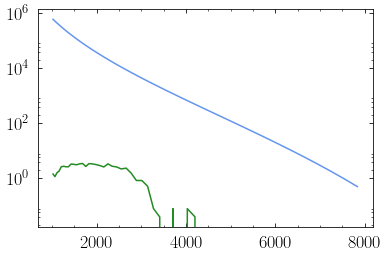

In [43]:
from math import *
bins=10**np.linspace(log10(1000),log10(8000),51)

def get_sig(mass, rinv, cut='Mt > 1000 & pt2> 120 & MEt > 200 & MEt > .15*Mt & dphi < 0.4  & 1.1 > eta1-eta2 > -1.1'):
    d = combine_signal_files('../data/sig_zprime/', mass, rinv)
    d = d.query(cut)
    sig, _ = np.histogram(d['Mt'],weights=d['weight'],bins=bins)
    return sig

bc=(bins[:-1]+bins[1:])/2.
bw=(bins[1:]-bins[:-1])
plt.plot(bc,bw*qcd(bins))
plt.plot(bc,get_sig(3000,0.6))
plt.yscale('log')
#plt.xscale('log')


In [44]:
from scipy.optimize import bisect
def limit(sig,bkg):
    if np.sum(sig)==0:
        return 1e99
    def func_root(x):
        part1 = bkg > 20
        part2 = np.logical_not(part1)
        qcd_1 = bkg[part1]
        qcd_2 = bkg[part2]
        sig_1 = sig[part1]
        sig_2 = sig[part2]

        sig_t1 = (10**x)*sig_1
        sig_t2 = (10**x)*sig_2
        
        sb1 = qcd_1 + sig_1
        sb2 = qcd_2 + sig_2
        
        normpart = sig_t1**2/(2*(sb1+0.0001**2*qcd_1**2))
        logpart = np.where(qcd_2 > 1e-3, -qcd_2*np.log(1+sig_t2/qcd_2), 0)
        my_val = np.sum(normpart)+(np.sum(logpart)+np.sum(sig_t2)) - 2
        return my_val
    
    
    soln = bisect(func_root, -10.,10.)
    return 10**soln

In [45]:
rinv=np.array([0,.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99,1])
masses=np.arange(1000,5001,100)

bins=10**np.linspace(log10(100),log10(8000),91)
bc=(bins[:-1]+bins[1:])/2.
bkg=qcd(bc)


result=np.zeros([len(rinv),len(masses)])
cxn=np.zeros([len(rinv),len(masses)])

for ir,r in enumerate(rinv):
    for im,m in enumerate(masses):
        sig=get_sig(m, r)
        result[ir,im]=limit(sig,bkg)
        d=get_data(m, r)
        cxn[ir,im]=np.array(d['cxn'])[0]
        print("{:1.2f}, {:d}, {:1.5f}".format(r,m,result[ir,im]))


0.00, 1000, 999999999999999967336168804116691273849533185806555472917961779471295845921727862608739868455469056.00000
0.00, 1100, 23.94989


/group/hepheno/heptools/anaconda3/envs/venv_py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 90 but corresponding boolean dimension is 89
/group/hepheno/heptools/anaconda3/envs/venv_py27/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 90 but corresponding boolean dimension is 89


0.00, 1200, 20.13465
0.00, 1300, 44.50195
0.00, 1400, 29.64928
0.00, 1500, 131.22837
0.00, 1600, 20.51873
0.00, 1700, 32.25973
0.00, 1800, 38.75100
0.00, 1900, 44.27728
0.00, 2000, 52.50715
0.00, 2100, 78.38625
0.00, 2200, 38.97700
0.00, 2300, 167.39925
0.00, 2400, 80.04408
0.00, 2500, 45.67572
0.00, 2600, 100.75931
0.00, 2700, 88.19266
0.00, 2800, 265.69932
0.00, 2900, 187.86238
0.00, 3000, 75.11533
0.00, 3100, 122.38743
0.00, 3200, 303.82126
0.00, 3300, 177.17536
0.00, 3400, 264.05565
0.00, 3500, 198.90115
0.00, 3600, 523.29478
0.00, 3700, 246.37625
0.00, 3800, 386.04893
0.00, 3900, 392.68640
0.00, 4000, 817.64973
0.00, 4100, 978.55907
0.00, 4200, 526.44080
0.00, 4300, 662.98059
0.00, 4400, 693.81228
0.00, 4500, 3168.50398
0.00, 4600, 462.58848
0.00, 4700, 1226.77983
0.00, 4800, 4980.75809
0.00, 4900, 695.78785
0.00, 5000, 1390.82978
0.01, 1000, 2.75683
0.01, 1100, 1.76153
0.01, 1200, 2.05217
0.01, 1300, 2.31365
0.01, 1400, 2.68564
0.01, 1500, 2.35164
0.01, 1600, 3.40712
0.01, 1700, 

In [46]:
def gq_disp(MZ):
    B = 10.
    Ld = 20.
    gd = 1
    return 1e-2*(1./gd)*(np.sqrt(B/10.))*(MZ/3000.)**2.*(20./Ld)**(5./2.)

sigma_disp = [cxn[4][iMZ]*(gq_disp(MZ)/.1)**2 for iMZ, MZ in enumerate(masses)]

In [47]:
# sigma_disp

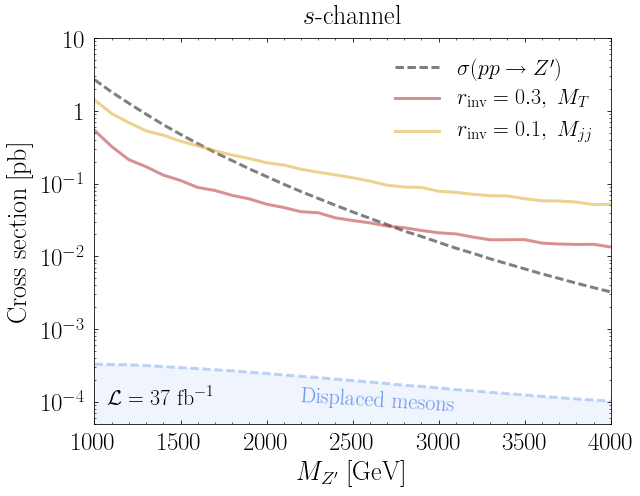

In [61]:
# print(result[4])
# print(cxn[4])

title='$s$-channel'

fig=plt.figure(figsize=(9,7))
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$M_{Z^\prime}$ [GeV]',fontsize=26)
plt.ylabel(r'$\textrm{Cross~section}\; [{\rm pb}]$',fontsize=26)  

# dijet=[ 0.91717632,  0.61706362,  0.46679191,  0.36953898,  0.32240986,  0.26982623,
#   0.22844323,  0.19783447,  0.17063068,  0.1498608,   0.1374028,   0.12254047,
#   0.10766884,  0.09746458,  0.08906787,  0.0794822,   0.07430999,  0.06567338,
#   0.05980109,  0.05777339,  0.05254686,  0.04881059,  0.0468448,   0.04493089,
#   0.04311289,  0.04064162,  0.03722523,  0.03508797,  0.03416082,  0.033527,
#   0.03310013]

dijet=[ 1.41554357,  0.91598026  ,0.68672405 , 0.53018732 , 0.46135803  ,0.38257651,
  0.32988437 , 0.28239812 , 0.24667282 , 0.22052391 , 0.193338   , 0.17968578,
  0.15699251 , 0.14337049 , 0.13140411 , 0.12011539 , 0.10808649 , 0.09494665,
  0.08951401 , 0.08851914 , 0.07825383 , 0.07570814 , 0.0710878  , 0.06804528,
  0.06767143 , 0.06187178 , 0.05798871 , 0.05751672 , 0.05575334 , 0.05137386,
  0.05191093]

plt.plot(masses, cxn[4], lw=3, label=r'$\sigma(pp\rightarrow Z^\prime)$',
         c='k',ls='--',alpha=.5)
plt.plot(masses, cxn[4]*result[4], 
         lw=3, label=r'$r_{\rm inv}=0.3, \; M_{T}$',ls='-',c='firebrick',alpha=.5)
plt.plot(masses[:len(dijet)], dijet, 
         lw=3,label=r'$r_{\rm inv}=0.1, \; M_{jj}$',ls='-',c='goldenrod',alpha=.5)

plt.plot(masses, sigma_disp, color='cornflowerblue' ,
         lw=3,alpha=.4,ls='--')
plt.fill_between(masses, sigma_disp, np.zeros(len(sigma_disp)), color='cornflowerblue' ,
         lw=0,alpha=.1)


plt.title(title, fontsize=26)


ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])



plt.xlim([1000,4000])
plt.ylim([5*1e-5,10])

plt.legend(loc='upper right',
           fontsize=22, ncol=1,frameon=False, fancybox=True)

plt.tick_params(axis='both', which='major', labelsize=25)


plt.yscale('log')

plt.text(1070,.9*10**-4,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=22)
# plt.text(3200,0.18, "$M_d = 10$ GeV", fontsize = 21)
# plt.text(1070,3.4*10**-3, "$g_x = 1.0$", fontsize = 21)
# plt.text(1070,1.7*10**-3, "$g_q = 0.1$", fontsize = 21)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "$10^{"+str(int(np.log10(x)))+"}$" if not (0.1 < x < 100) else "$" + str(int(x)) + "$"))

ax.text(2200,1.e-4,"Displaced mesons",fontsize=22, color='cornflowerblue', rotation=-3.5)



plt.tight_layout()
plt.savefig("schannel_cxn_lims.pdf")



[ 0.    0.01  0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   0.99
  1.  ]
[ -3.11838306e-07   3.62735151e+02   2.21725070e+03   2.67202049e+03
   2.72894906e+03   2.65248424e+03   2.47473777e+03   2.15722562e+03
   1.64585617e+03   1.10064541e+03   4.94168462e+02   4.00149743e+02
   2.55476020e+02]
[    0.           362.73515126  2217.25069976  2672.0204896   2728.9490603
  2652.48424035  2474.73776734  2157.22562032  1645.85617429  1100.64541195
     0.             0.             0.        ]
[    0.           362.73515126  2217.25069976  2672.0204896   2728.9490603
  2652.48424035  2474.73776734  2157.22562032  1645.85617429  1100.64541195
     0.             0.             0.        ]


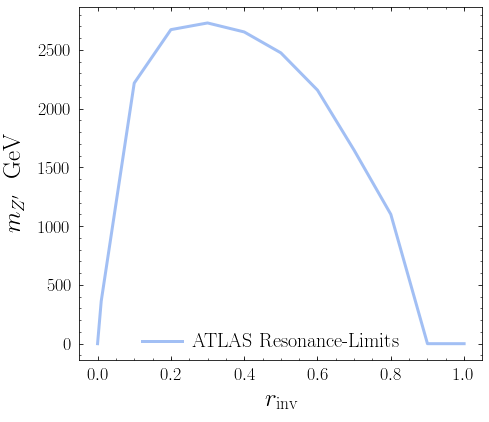

In [222]:
# from scipy.optimize import fsolve

mass_limit=np.zeros(len(rinv))
for i,r in enumerate(rinv):
    mymass = np.insert(masses,0,0)
    masslist = np.insert(result[i],0,0)    
    mass_limit[i] = fsolve(lambda mZ: 1-np.interp(mZ, mymass, masslist), 100)[0]

final_limit=mass_limit
print(rinv)
print(final_limit)
final_limit[:1]=0
final_limit[-3:]=0
print(final_limit)


plt.figure()

fig=plt.figure("m", figsize=(8,7))
plt.subplots_adjust(left=0.2, right=0.90, top=0.9, bottom=0.2)


plt.xlabel(r'$ r_{\rm inv}$', fontsize=25)
plt.ylabel(r'$ m_{Z^\prime}\,\,{\rm\; GeV}$', fontsize=25)
plt.plot(rinv,final_limit,lw=3,alpha=.6, label=r'$\textrm{ATLAS Resonance-Limits}$')

plt.legend(bbox_to_anchor=(0, 0, .95, 0.95),
           fontsize=20, ncol=1,frameon=False,
           handletextpad=.5, columnspacing=.8,
           borderaxespad=0.)


print(final_limit)
# plt.savefig("tim_zprime_res.pdf")

plt.show()

In [ ]:
test